# Starbucks Capstone Challenge

## Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

## Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

## Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

## Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## CHANGES!!

- Project Overview: ammend the cell above
- high-level overview of project
- problem domain
- project origin
- related datasets/input data

- Does gender correlate to how much someone spends at Starbucks?
- How many people view and complete offers? And how many people complete offers without opening them first?
- Which offer type is the most likely to be completed after viewed?
- What are the attributes that most contribute to someone’s spending habits at Starbucks?

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [68]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [69]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [70]:
profile.head() 

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [71]:
transcript.head() 

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Problem statement: define problem that needs to be solved; strategy for solving problem; discussion of expected solution

Metrics: which ones I'll use for the problem and why

# Data Cleaning

## Portfolio Data

In [72]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [73]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [74]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [75]:
# check for missing values
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

- create a copy of the original dataframe for further implementation .
- convert the column 'Channels' into 4 different channel on the basis of different types of channel.
- convert the column 'offer_type' into 3 columns on the basis of different types of offers.
- rename the column name from 'id' to 'offer_id'.

In [76]:
portfolio_clean = portfolio.copy()
dummy_channels = pd.get_dummies(portfolio_clean['channels'].explode()).groupby(level=0).sum()
dummy_offertype = pd.get_dummies(portfolio['offer_type']).groupby(level=0).sum()

portfolio_clean = pd.concat([portfolio_clean, dummy_channels], axis=1)
portfolio_clean = pd.concat([portfolio_clean, dummy_offertype], axis=1)

portfolio_clean = portfolio_clean.drop(columns='channels')
portfolio_clean = portfolio_clean.rename(columns={'id':'offer_id'})
portfolio_clean.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


## Profile Data

In [77]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [78]:
# check the missing values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [79]:
# what percentage of income (and gender) data is missing
round(100*profile['income'].isna().sum()/profile.shape[0],2)
#tempted to drop these rows since it's <1%

12.79

In [80]:
# check the number of duplicated rows
profile.duplicated(subset=['id']).sum()

0

In [81]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


- create a copy of the original dataframe for further implementation.
- convert the datatype of 'became_member_on' column and sort the date into proper format.
- change the column name from 'id' to 'customer_id'.
- extract membership year and make into a new column.
- make dummy columns for membership year.
- make dummy columns for gender

In [82]:
profile_clean = profile.copy()
profile_clean['membership_year'] = profile_clean['became_member_on'].astype(str).apply(lambda x: x[0:4])
profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'], format='%Y%m%d')

gender_dummies = profile_clean['gender'].str.get_dummies().add_prefix('gender_')
year_joined_dummies = profile_clean['membership_year'].str.get_dummies().add_prefix('year_joined_')

profile_clean = pd.concat([profile_clean, gender_dummies, year_joined_dummies], axis=1)
profile_clean = profile_clean.rename(columns={'id':'customer_id'})
profile_clean.head()

,gender,age,customer_id,became_member_on,income,membership_year,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,0,0,0,0,0,0,0,1,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,1,0,0,0,0,0,0,1,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,0,0,0,0,0,0,0,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,1,0,0,0,0,0,0,1,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,0,0,0,0,0,0,0,1,0


In [83]:
profile_missing = profile_clean[profile_clean['income'].isna()]
profile_missing.isnull().sum()
# looks like all missing gender and income values are on the same rows. Explore age and became_member_on columns

gender              2175
age                    0
customer_id            0
became_member_on       0
income              2175
membership_year        0
gender_F               0
gender_M               0
gender_O               0
year_joined_2013       0
year_joined_2014       0
year_joined_2015       0
year_joined_2016       0
year_joined_2017       0
year_joined_2018       0
dtype: int64

In [84]:
profile_missing.describe()
# looks like all have missing ages too, so these rows will not be useful for demographic exploratory analysis
# will drop them later, after merging with other datasets as we'll need to know the customer_id number for ones to drop

,age,became_member_on,income,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
count,2175.0,2175,0.0,2175.0,2175.0,2175.0,2175.000000,2175.000000,2175.000000,2175.000000,2175.000000,2175.000000
mean,118.0,2017-03-29 19:53:42.620689920,NaN,0.0,0.0,0.0,0.005517,0.013333,0.107126,0.230805,0.400000,0.243218
min,118.0,2013-08-02 00:00:00,NaN,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,118.0,2016-07-04 12:00:00,NaN,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,118.0,2017-07-31 00:00:00,NaN,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,118.0,2017-12-26 00:00:00,NaN,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,118.0,2018-07-26 00:00:00,NaN,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,0.0,NaN,NaN,0.0,0.0,0.0,0.074090,0.114724,0.309345,0.421445,0.490011,0.429125


In [85]:
profile_clean[profile_clean['age'] == 118].count()
# all times where age has been missing, gender and income have been missing too

gender                 0
age                 2175
customer_id         2175
became_member_on    2175
income                 0
membership_year     2175
gender_F            2175
gender_M            2175
gender_O            2175
year_joined_2013    2175
year_joined_2014    2175
year_joined_2015    2175
year_joined_2016    2175
year_joined_2017    2175
year_joined_2018    2175
dtype: int64

## Transcript Data

In [86]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [87]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [88]:
# check for missing values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [89]:
transcript['event'].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [90]:
transcript[transcript['event'] == 'offer received']['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
257882    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
257883    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
257884    {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
257885    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
257886    {'offer id': '3f207df678b143eea3cee63160fa8bed'}
Name: value, Length: 76277, dtype: object

In [91]:
transcript[transcript['event'] == 'offer viewed']['value']

12650     {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651     {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652     {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653     {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655     {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
                                ...                       
306441    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
306450    {'offer id': '3f207df678b143eea3cee63160fa8bed'}
306483    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
306490    {'offer id': '3f207df678b143eea3cee63160fa8bed'}
306507    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
Name: value, Length: 57725, dtype: object

In [92]:
transcript[transcript['event'] == 'transaction']['value']

12654     {'amount': 0.8300000000000001}
12657                  {'amount': 34.56}
12659                  {'amount': 13.23}
12670                  {'amount': 19.51}
12671                  {'amount': 18.97}
                       ...              
306529    {'amount': 1.5899999999999999}
306530                  {'amount': 9.53}
306531                  {'amount': 3.61}
306532    {'amount': 3.5300000000000002}
306533                  {'amount': 4.05}
Name: value, Length: 138953, dtype: object

In [93]:
transcript[transcript['event'] == 'offer completed']['value']

12658     {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672     {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679     {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692     {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697     {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
                                ...                        
306475    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
306497    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
306506    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306509    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306527    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
Name: value, Length: 33579, dtype: object

In [94]:
transcript[transcript['event'] == 'offer completed']['value'].iloc[0]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

has offer id for offer received/viewed/completed, but amount for transaction

- create a copy of the original dataframe for further implementation .
- change the column name from 'person' to 'customer_id' .
- convert the column 'Event' into 4 different columns on the basis of different types of event .
- convert the column 'Values' into 2 different column .

In [95]:
transcript_clean = transcript.copy()
transcript_clean = transcript_clean.rename(columns={'person':'customer_id'})
transcript_clean['event'] = transcript_clean['event'].str.replace(' ', '-')
dummy = pd.get_dummies(transcript_clean['event'])
dummy.replace({False: 0, True: 1}, inplace=True)
transcript_clean = pd.concat([transcript_clean, dummy], axis=1)
transcript_clean.head()

,customer_id,event,value,time,offer-completed,offer-received,offer-viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer-received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


In [96]:
def offer_dict(value):
    if 'offer_id' in value:
        return value['offer_id']
    if 'offer id' in value:
        return value['offer id']
    else:
        return np.NaN

transcript_clean['offer_id'] = transcript_clean['value'].map(offer_dict)

In [97]:
def amount_dict(value):
    if 'amount' in value:
        return value['amount']
    else:
        return np.NaN
    
transcript_clean['amount'] = transcript_clean['value'].map(amount_dict)

In [98]:
def reward_dict(value):
    if 'reward' in value:
        return value['reward']
    else:
        return np.NaN
    
transcript_clean['reward'] = transcript_clean['value'].map(reward_dict)

In [99]:
transcript_clean.drop(columns=['value'], inplace=True)

In [100]:
transcript_clean.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer-received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


## Merge data

- Concatenate all the three dataset together .
- Fixed the Offer_ids
- fixed event_ids

In [101]:
temp_merge = pd.merge(transcript_clean, profile_clean, on='customer_id')
temp_merge.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,reward,...,membership_year,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,...,2017,1,0,0,0,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,...,2017,1,0,0,0,0,0,0,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,NaN,19.89,NaN,...,2017,1,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,...,2017,1,0,0,0,0,0,0,1,0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,NaN,17.78,NaN,...,2017,1,0,0,0,0,0,0,1,0


In [102]:
df_merge = pd.merge(temp_merge, portfolio_clean, on='offer_id', how='left')
df_merge.sort_values(by = ['customer_id', 'time'], inplace=True)
df_merge.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,reward_x,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
282869,0009655768c64bdeb2e877511632db8f,offer-received,168,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,...,0.0,3.0,informational,1.0,1.0,1.0,0.0,0.0,0.0,1.0
282870,0009655768c64bdeb2e877511632db8f,offer-viewed,192,0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,...,0.0,3.0,informational,1.0,1.0,1.0,0.0,0.0,0.0,1.0
282871,0009655768c64bdeb2e877511632db8f,transaction,228,0,0,0,1,NaN,22.16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282872,0009655768c64bdeb2e877511632db8f,offer-received,336,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,...,0.0,4.0,informational,1.0,1.0,0.0,1.0,0.0,0.0,1.0
282873,0009655768c64bdeb2e877511632db8f,offer-viewed,372,0,0,1,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,...,0.0,4.0,informational,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [103]:
df_merge.shape

(306534, 35)

In [104]:
df_merge.columns

Index(['customer_id', 'event', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'reward_x',
       'gender', 'age', 'became_member_on', 'income', 'membership_year',
       'gender_F', 'gender_M', 'gender_O', 'year_joined_2013',
       'year_joined_2014', 'year_joined_2015', 'year_joined_2016',
       'year_joined_2017', 'year_joined_2018', 'reward_y', 'difficulty',
       'duration', 'offer_type', 'email', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational'],
      dtype='object')

In [105]:
# going back to those 2175 customers with missing age, gender and income data
profile_missing = df_merge[df_merge['income'].isna()]
len(profile_missing.customer_id.value_counts().index)

# now that we have those people matched by their customer ids, we can drop the rows
df_merge.dropna(subset=['income'], inplace=True)

## Exploratory Data Analysis

### Customer Demographics

#### Age Distribution

In [106]:
profile_clean.dropna(subset=['income'], inplace=True)

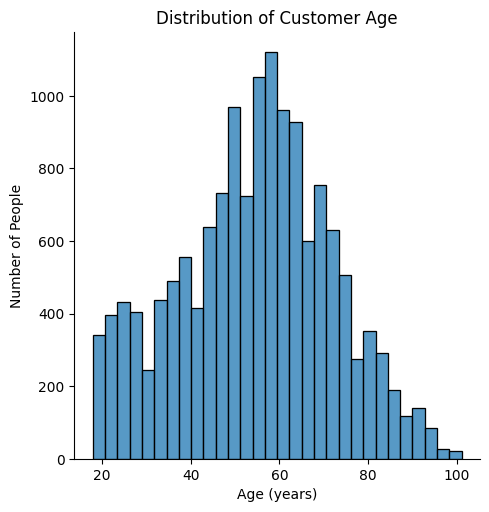

In [107]:
ax = sns.displot(profile_clean, x='age', bins=30)
ax.set(title='Distribution of Customer Age', xlabel='Age (years)', ylabel='Number of People');

In [108]:
print('Mean age of customers: ', profile_clean['age'].mean())
print('Median age of customers: ', profile_clean['age'].median())
# left skewed

Mean age of customers:  54.39352445193929
Median age of customers:  55.0


Mean = 54.4, median = 55, slightly left skewed, majority of customers are between 50-70

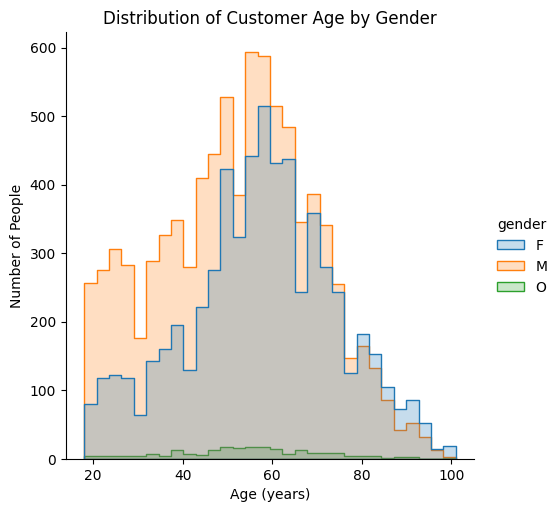

In [109]:
ax = sns.displot(profile_clean, x='age', hue='gender', element='step', bins=30)
ax.set(title='Distribution of Customer Age by Gender', xlabel='Age (years)', ylabel='Number of People');

more men 20-50ish

#### Gender Distribution

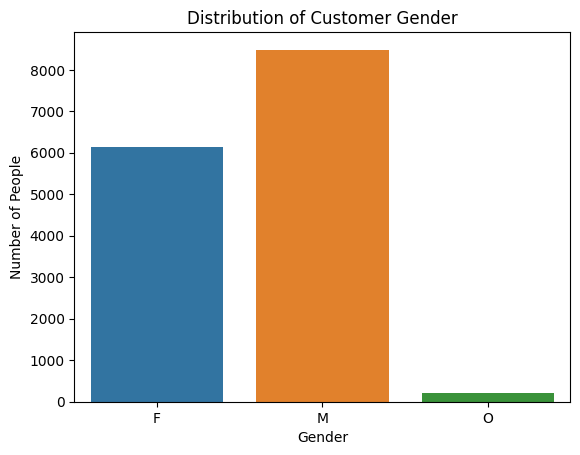

In [110]:
ax = sns.countplot(profile_clean, x='gender')
ax.set(title='Distribution of Customer Gender', xlabel='Gender', ylabel='Number of People');

In [111]:
gender_props = pd.DataFrame(profile_clean['gender'].value_counts())
gender_props['proportion'] = gender_props['count']/profile_clean.shape[0]
gender_props

,count,proportion
gender,,
M,8484,0.572277
F,6129,0.413423
O,212,0.014300


57% are male, 41% female therefore majority are male, approx 200 identify as other

#### Income Distribtuion

In [112]:
print('Mean income of customers: ', profile_clean['income'].mean())
print('Median income of customers: ', profile_clean['income'].median())
# right skewed

Mean income of customers:  65404.9915682968
Median income of customers:  64000.0


Mean = 65405, median = 64000, right skewed

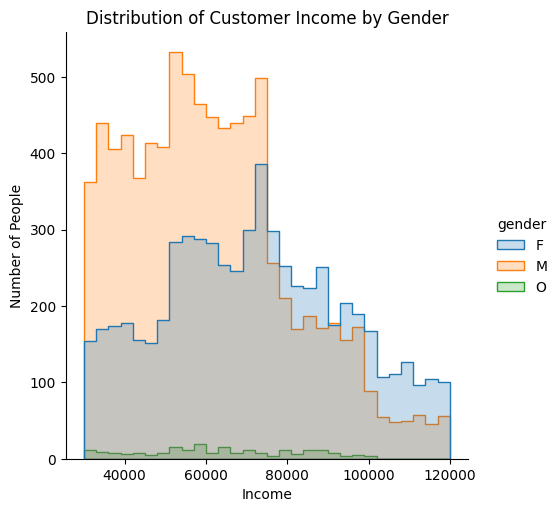

In [113]:
ax = sns.displot(profile_clean, x='income', hue='gender', element='step', bins=30)
ax.set(title='Distribution of Customer Income by Gender', xlabel='Income', ylabel='Number of People');

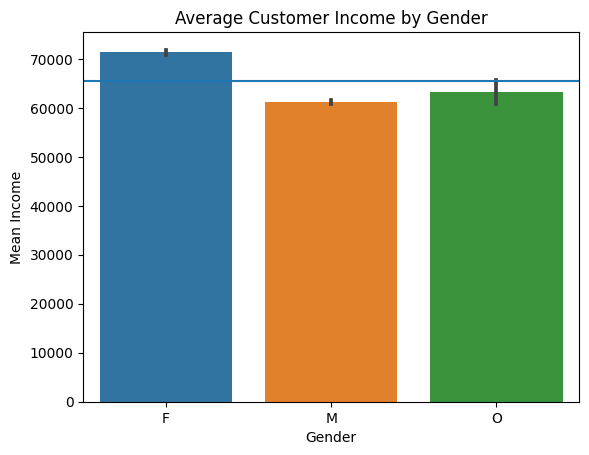

In [114]:
ax = sns.barplot(data=profile_clean, x="gender", y="income")
ax.axhline(y=profile_clean['income'].mean());
ax.set(title='Average Customer Income by Gender', xlabel='Gender', ylabel='Mean Income');

The chart above shows that on average, females earn significantly higher than males and other gender of the customers

females earn significantly higher than the general average.

### Offer Type Analysis

In [115]:
channel_count = pd.DataFrame(portfolio_clean[['email', 'mobile', 'social', 'web']].sum()).reset_index(names='channel').rename(columns={0:'count'})
type_count = pd.DataFrame(portfolio_clean[['bogo', 'discount', 'informational']].sum()).reset_index(names='offer_type').rename(columns={0:'count'})
channel_count

,channel,count
0,email,10
1,mobile,9
2,social,6
3,web,8


email and mobile most common, all offers communicated by email

In [116]:
type_count

,offer_type,count
0,bogo,4
1,discount,4
2,informational,2


In [117]:
test = pd.DataFrame(portfolio_clean[['offer_type','email', 'mobile', 'social', 'web']].groupby('offer_type').sum().reset_index())

discount offers more common by web or email, whereas bogo and informational were more common by email and mobile

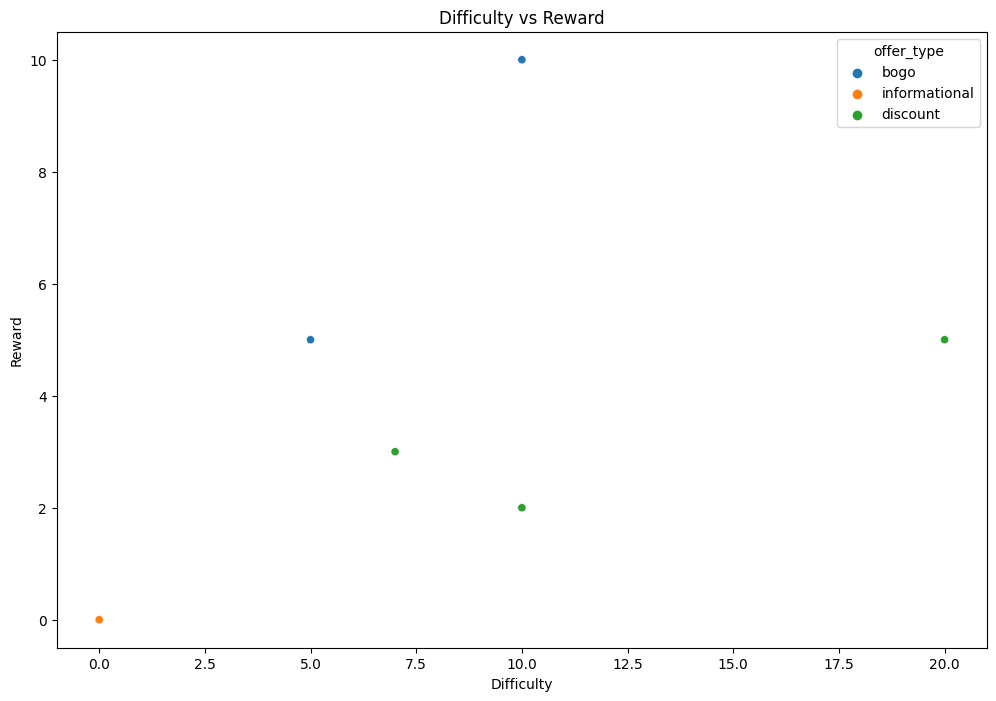

In [118]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(portfolio_clean, x='difficulty', y='reward', hue='offer_type')
ax.set(title='Difficulty vs Reward', xlabel='Difficulty', ylabel='Reward');

discount offers seemed to have less reward for the difficulty, whereas bogo ofc course had same reward for difficulty

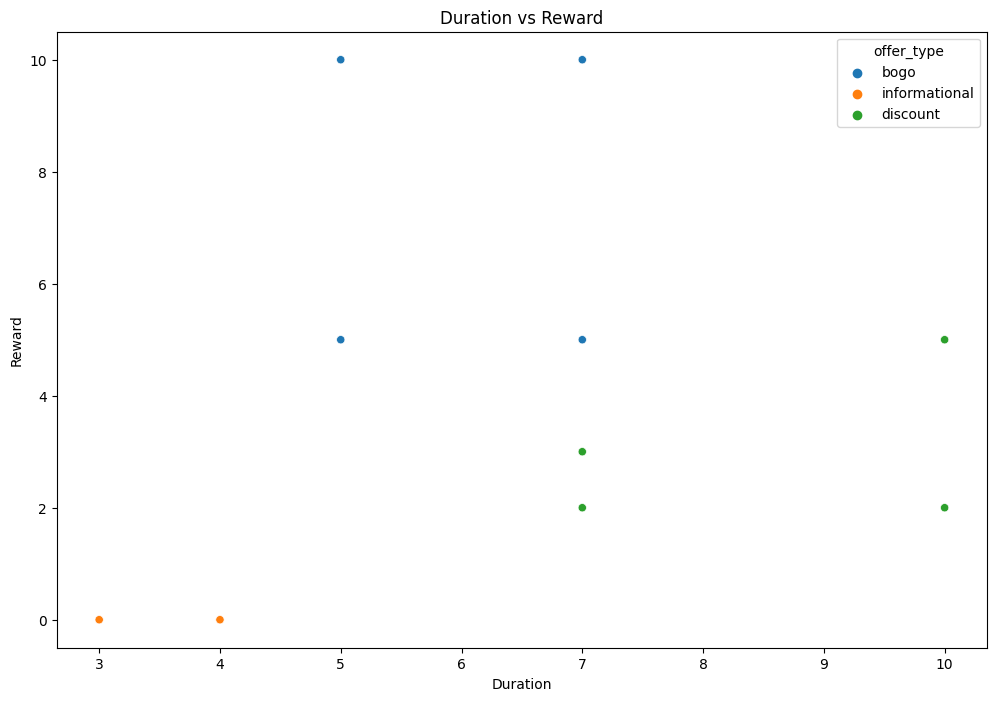

In [119]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(portfolio_clean, x='duration', y='reward', hue='offer_type')
ax.set(title='Duration vs Reward', xlabel='Duration', ylabel='Reward');

discount offers lasted longer than bogo but had less reward
bogo offers were shorter than discount offers and had more reward

In [120]:
df_merge[df_merge['offer-received'] == 1][['email', 'mobile', 'social', 'web']].sum()

email     66501.0
mobile    59775.0
social    39802.0
web       53175.0
dtype: float64

most offers sent by email, then web, then mobile then social

In [121]:
df_merge[df_merge['offer-received'] == 1][['bogo', 'discount', 'informational']].sum()

bogo             26537.0
discount         26664.0
informational    13300.0
dtype: float64

slightly more discount offers sent out than bogo, informational is half of this

### Transaction/Gender Analysis

In [122]:
transaction_df = df_merge[df_merge['transaction'] == 1]

transaction_df_F = transaction_df[transaction_df['gender_F'] == 1]
transaction_df_M = transaction_df[transaction_df['gender_M'] == 1]
transaction_df_O = transaction_df[transaction_df['gender_O'] == 1]

In [123]:
transaction_gender_df = pd.DataFrame(transaction_df_F['amount'].describe()).rename(columns={'amount':'Amount_F'})
transaction_gender_df['Amount_M'] = list(transaction_df_M['amount'].describe())
transaction_gender_df['Amount_O'] = list(transaction_df_O['amount'].describe())

transaction_gender_df['Income_F'] = list(transaction_df_F['income'].describe())
transaction_gender_df['Income_M'] = list(transaction_df_M['income'].describe())
transaction_gender_df['Income_O'] = list(transaction_df_O['income'].describe())
transaction_gender_df

,Amount_F,Amount_M,Amount_O,Income_F,Income_M,Income_O
count,49382.000000,72794.000000,1781.000000,49382.000000,72794.000000,1781.000000
mean,17.490077,11.606600,14.798731,66813.960552,58491.317966,61039.865244
std,35.342611,28.964542,25.748149,21965.016643,19048.170156,19009.521115
min,0.050000,0.050000,0.050000,30000.000000,30000.000000,30000.000000
25%,7.970000,2.570000,7.010000,51000.000000,43000.000000,47000.000000
50%,15.000000,7.050000,13.300000,65000.000000,56000.000000,60000.000000
75%,22.120000,16.220000,19.290000,82000.000000,70000.000000,74000.000000
max,1062.280000,977.780000,713.120000,120000.000000,120000.000000,100000.000000


The final chart (table) gives more detailed statistics on Amount, Age, and Income separated by Gender. It shows that Women clearly spend more than Men do, with higher mean and deviation. Contrary to the early plot on raw data, we see that the age of most spenders is similar for both men and women. Finally, the biggest disparity we see is in Income. Higher mean and 25/50/70 percentage quantile shows that the average Female spender earns more than the average Male spender.

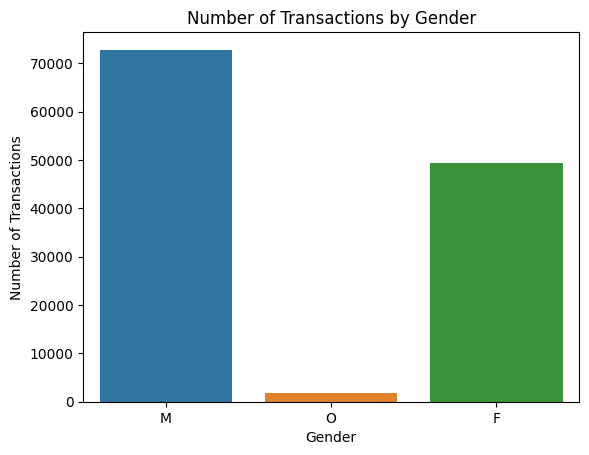

In [124]:
ax = sns.countplot(transaction_df, x='gender')
ax.set(title='Number of Transactions by Gender', xlabel='Gender', ylabel='Number of Transactions');

In [125]:
print('Average number of transactions per female customer:', transaction_df_F['amount'].count()/transaction_df_F['customer_id'].nunique())
print('Average number of transactions per male customer:', transaction_df_M['amount'].count()/transaction_df_M['customer_id'].nunique())
print('Average number of transactions per other customer:', transaction_df_O['amount'].count()/transaction_df_O['customer_id'].nunique())

Average number of transactions per female customer: 8.239946604371767
Average number of transactions per male customer: 8.775647980711272
Average number of transactions per other customer: 8.730392156862745


- females on average spend more than males or other (17.5 vs 11.6), but females on average were earning more too
- we see a lot more records of transactions for men than women (72794 vs 49382)
- average number of transactions per customer in each gendered dataset is roughly the same, slightly higher for males.

In [166]:
transaction_amount = transaction_df[['customer_id', 'amount']].groupby(['customer_id']).sum(['amount']).reset_index()
transaction_count = transaction_df[['customer_id', 'amount']].groupby(['customer_id']).count().reset_index().rename(columns={'amount':'count'})

transaction_plot_df = pd.merge(transaction_amount, transaction_count, on='customer_id')
transaction_plot_df = pd.merge(transaction_plot_df, profile_clean[['customer_id','gender']], on='customer_id')
transaction_plot_df

,customer_id,amount,count,gender
0,0009655768c64bdeb2e877511632db8f,127.60,8,M
1,0011e0d4e6b944f998e987f904e8c1e5,79.46,5,O
2,0020c2b971eb4e9188eac86d93036a77,196.86,8,F
3,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,F
4,003d66b6608740288d6cc97a6903f4f0,48.34,18,F
...,...,...,...,...
14487,fff3ba4757bd42088c044ca26d73817a,580.98,11,F
14488,fff7576017104bcc8677a8d63322b5e1,29.94,6,M
14489,fff8957ea8b240a6b5e634b6ee8eafcf,12.15,5,M
14490,fffad4f4828548d1b5583907f2e9906b,88.83,12,M


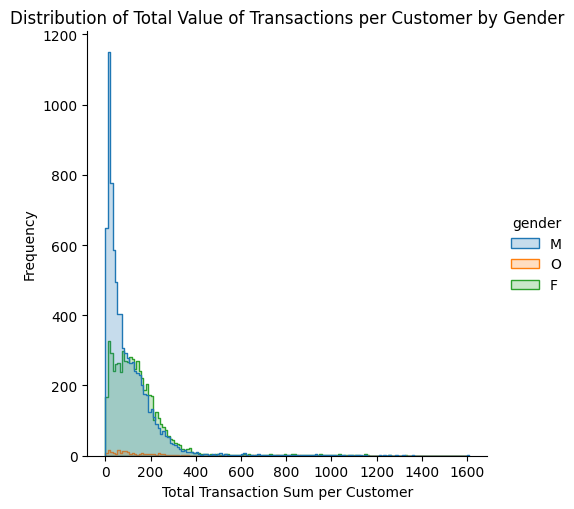

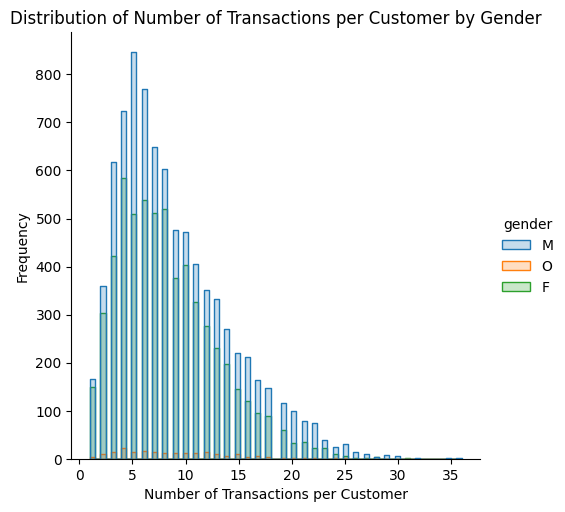

In [167]:
sns.displot(transaction_plot_df, x="amount", hue='gender', element='step').set(title='Distribution of Total Value of Transactions per Customer by Gender', xlabel='Total Transaction Sum per Customer', ylabel='Frequency')
sns.displot(transaction_plot_df, x="count", hue='gender', element='step').set(title='Distribution of Number of Transactions per Customer by Gender', xlabel='Number of Transactions per Customer', ylabel='Frequency')

*This answers our first question on the influence of gender of purchases. Women spend more at Starbucks then Men do, with an average difference of about 6 dollars per purchase*.

### Completion Trails Analysis

#### Completed in General

In [128]:
offer_compl_df = df_merge[df_merge['offer-completed'] == 1].groupby(['offer_id']).count()[['customer_id']].reset_index().rename(columns={'customer_id':'count'})
offer_compl_df = pd.merge(offer_compl_df, portfolio_clean[['offer_id','bogo','discount','informational']], on='offer_id').sort_values(by='count', ascending=False)
offer_compl_df

,offer_id,count,bogo,discount,informational
7,fafdcd668e3743c1bb461111dcafc2a4,5003,0,1,0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,4886,0,1,0
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,4188,1,0,0
6,f19421c1d4aa40978ebb69ca19b0e20d,4103,1,0,0
2,2906b810c7d4411798c6938adc9daaa5,3911,0,1,0
5,ae264e3637204a6fb9bb56bc8210ddfd,3657,1,0,0
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,3386,0,1,0
3,4d5c57ea9a6940dd891ad53e9dbe8da0,3310,1,0,0


In [129]:
print('Number of completed BOGO offers:',offer_compl_df[offer_compl_df['bogo']==1]['count'].sum())
print('Number of completed discount offers:',offer_compl_df[offer_compl_df['discount']==1]['count'].sum())
print('Number of completed informational offers:',offer_compl_df[offer_compl_df['informational']==1]['count'].sum())

Number of completed BOGO offers: 15258
Number of completed discount offers: 17186
Number of completed informational offers: 0


- top offers to be completed by customers were discount offers
- no informational offers were completed, probably because there is no difficulty of reward

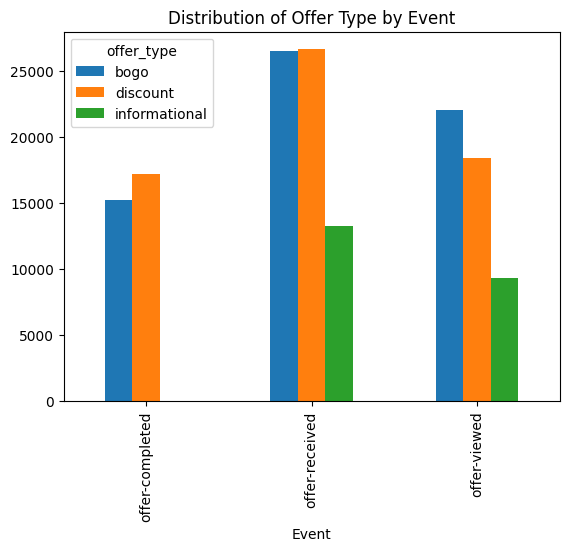

In [130]:
# plot clustered bar chart
df_merge.groupby(['event', 'offer_type']).size().unstack().plot(kind='bar', stacked=False)
plt.title('Distribution of Offer Type by Event')
plt.xlabel('Event')
plt.show()

from the above chart, it can be seen that customers mostly received bogo and discount however, they mostly viewed bogo. Even though they viewed more bobo, offers thay mostly completed were discounts.

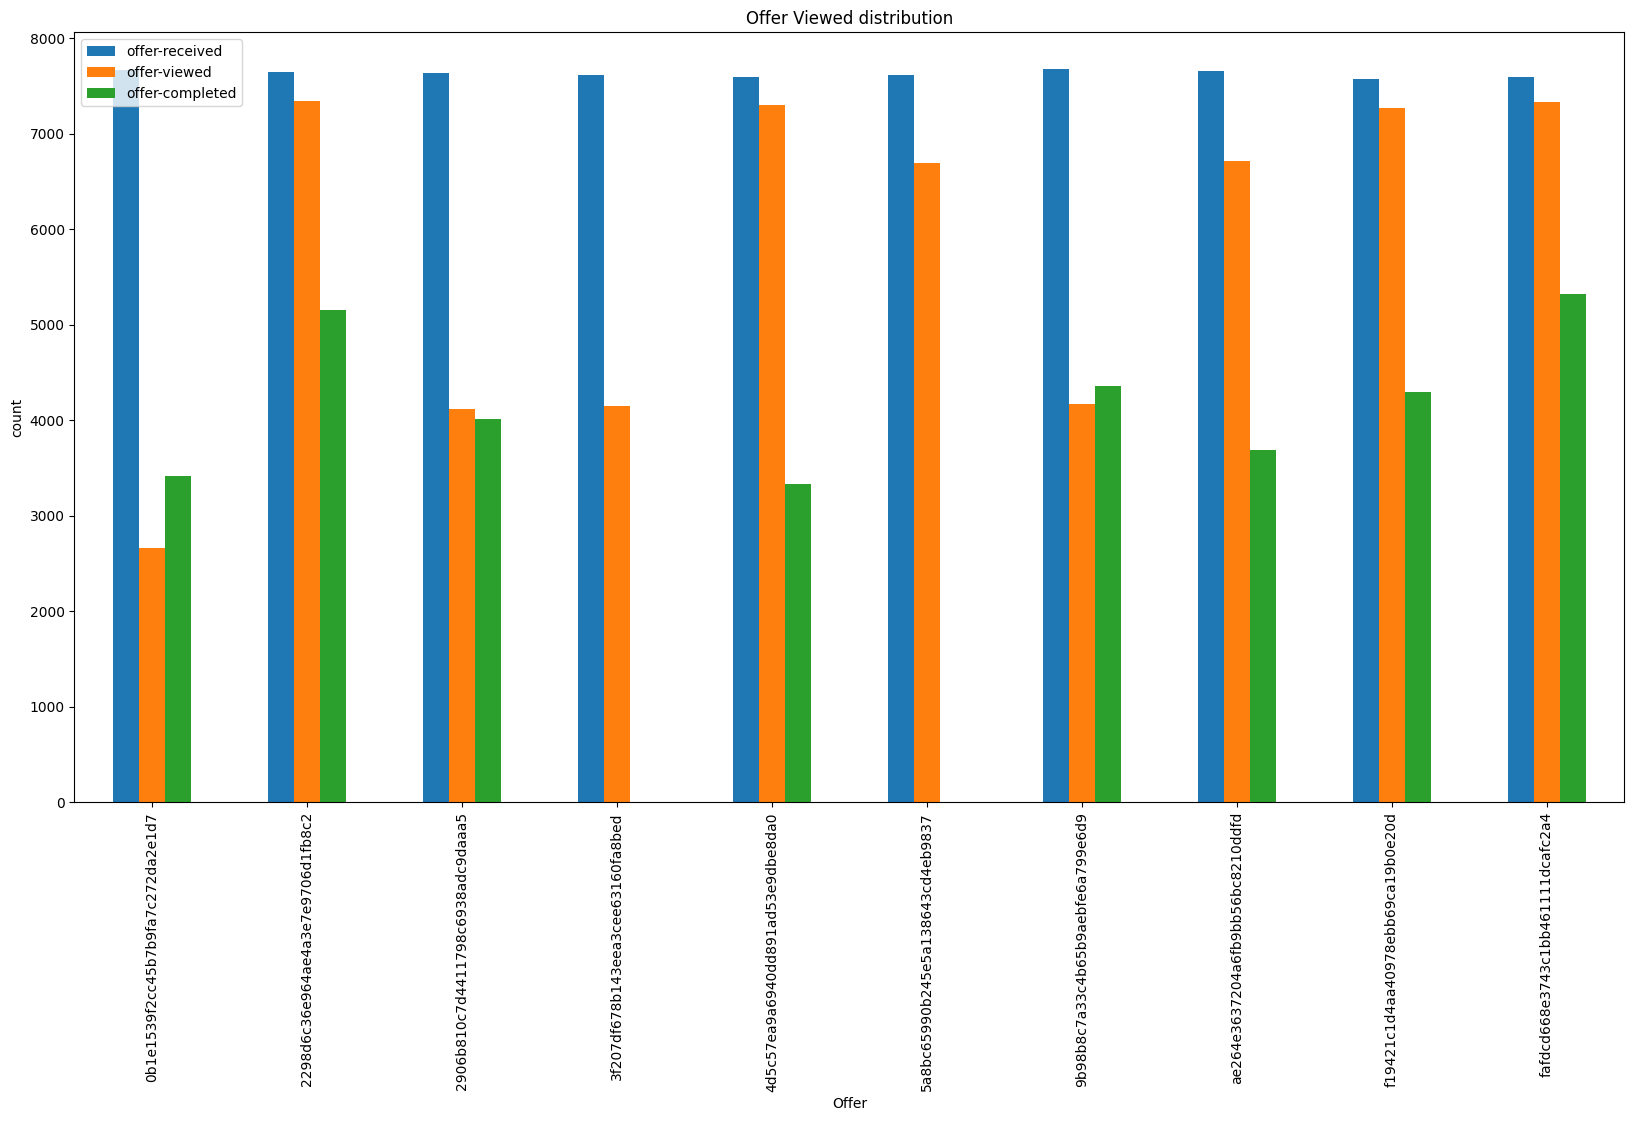

In [131]:
plt.rcParams["figure.figsize"] = (20,10)
transcript_clean.groupby('offer_id').sum().plot(kind='bar', y=['offer-received','offer-viewed','offer-completed'])
plt.title('Offer Viewed distribution')
plt.ylabel('count')
plt.xlabel('Offer');

#### Completed after viewing the offer

In [133]:
transcript_portfolio = pd.merge(transcript_clean, portfolio_clean, on='offer_id')
transcript_by_group = transcript_portfolio.groupby(['customer_id', 'offer_id'])

In [154]:
%%time

completion_details = [];

for pair,  in transcript_by_group:
    record = {};
    event = list(g['event'])
    
    if all(item in event for item in ['offer-received', 'offer-viewed', 'offer-completed']):
        if event.index('offer-viewed') < event.index('offer-completed'):
            record['status'] = 'completed_after_viewed';
        else:
            record['status'] = 'completed_before_viewed';
    elif all(item in event for item in ['offer-received', 'offer-completed']) and ('offer-viewed' not in event):
        record['status'] = 'not_viewed_but_completed';
    else:
        record['status'] = 'not_completed';

    person_id, offer_id = g['customer_id'].iloc[0], g['offer_id'].iloc[0];
    record['customer_id'], record['offer_id'] = person_id, offer_id;

    completion_details.append(record);

completion_details_df = pd.DataFrame(completion_details)

CPU times: total: 4.66 s
Wall time: 9.39 s


In [164]:
status_df = pd.DataFrame(completion_details_df['status'].value_counts()).reset_index()
status_df['proportion'] = status_df['count']/completion_details_df.shape[0]
status_df

,status,count,proportion
0,not_completed,34292,0.541840
1,completed_after_viewed,20752,0.327898
2,not_viewed_but_completed,4536,0.071672
3,completed_before_viewed,3708,0.058589


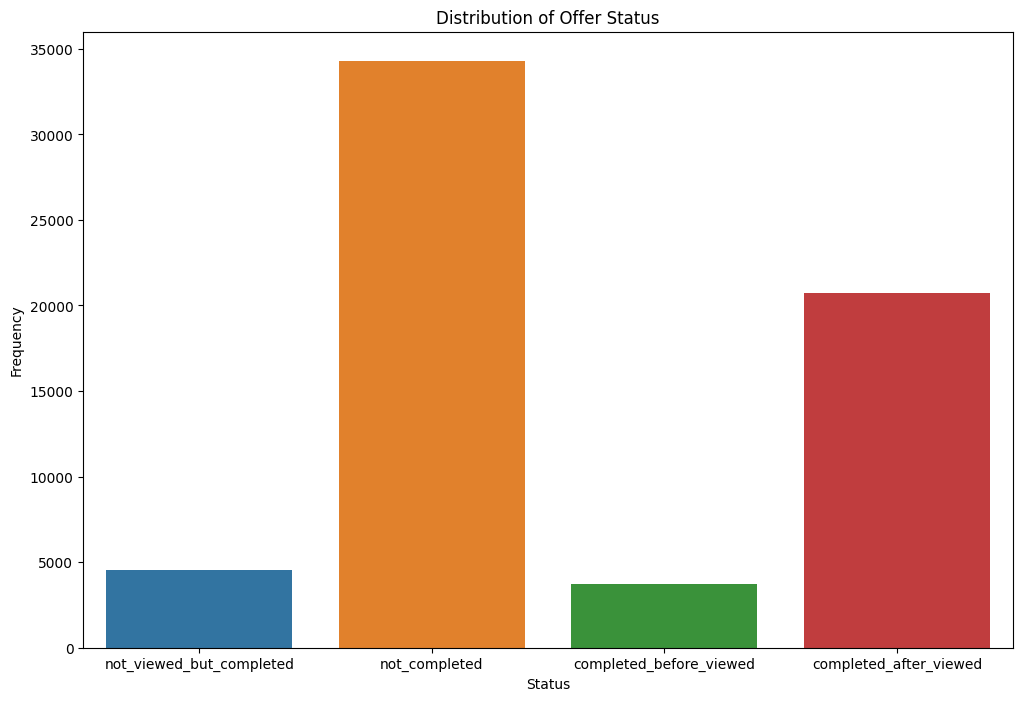

In [168]:
plt.figure(figsize=(12,8))
ax = sns.countplot(completion_details_df, x='status');
ax.set(title='Distribution of Offer Status', xlabel='Status', ylabel='Frequency');

- 'not_completed' status includes the offers which were recieved, as well as those that were received and viewed. Most of the offer statuses fall into this category (54%)
- 33% of offers had a 'proper' completion trail of offer being received, then viewed, the completed. This was the second most common offer status and 20752 people.
- 13% were offers that were completed and either not viewed or viewed afterwards.
- 28,996 people utilised an offer

In [180]:
completed_offers = pd.DataFrame(completion_details_df[completion_details_df['status'] == 'completed_after_viewed']['offer_id'].value_counts()).reset_index()
pd.merge(completed_offers, portfolio_clean, on='offer_id')

,offer_id,count,reward,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,fafdcd668e3743c1bb461111dcafc2a4,4033,2,10,10,discount,1,1,1,1,0,1,0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,3820,3,7,7,discount,1,1,1,1,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,3129,5,5,5,bogo,1,1,1,1,1,0,0
3,4d5c57ea9a6940dd891ad53e9dbe8da0,2436,10,10,5,bogo,1,1,1,1,1,0,0
4,ae264e3637204a6fb9bb56bc8210ddfd,2314,10,10,7,bogo,1,1,1,0,1,0,0
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1922,5,5,7,bogo,1,1,0,1,1,0,0
6,2906b810c7d4411798c6938adc9daaa5,1891,2,10,7,discount,1,1,0,1,0,1,0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1207,5,20,10,discount,1,0,0,1,0,1,0


In [181]:
pd.merge(completed_offers, portfolio_clean, on='offer_id').groupby('offer_type')['count'].sum()

offer_type
bogo         9801
discount    10951
Name: count, dtype: int64

appears that discount is both the most common and least common type of offer to be completed after viewed. Overall, 1150 more discount offers where completed after being viewed than BOGO offers.

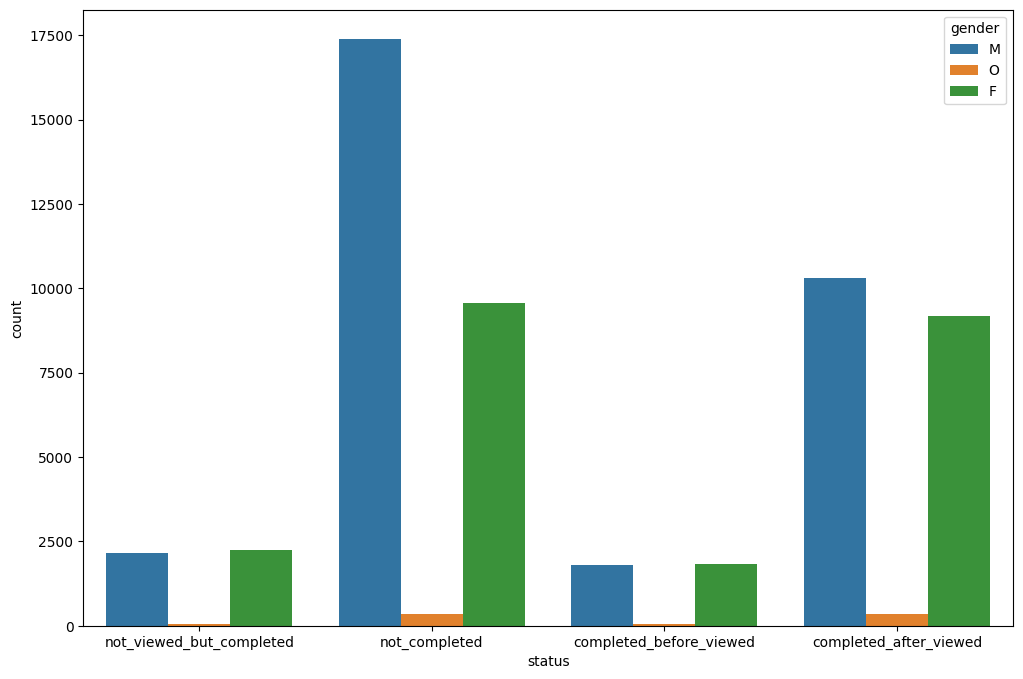

In [193]:
plt.figure(figsize=(12,8))
sns.countplot(pd.merge(completion_details_df, profile_clean[['customer_id','gender']], on='customer_id'), x = 'status', hue='gender')
ax.set(title='Distribution of Offer Status by Gender', xlabel='Status', ylabel='Frequency');

- A lot more men than women didn't complete offers, whereas for the 'proper' completion track of completion_after_viewed, the difference between the 2 is a lot smaller.

(3rd tab) bogo and informational seems like it doesn't relate with any features. Does it mean these two offers are randomly offered?!

discount is relate with difficulty and duration. This might means the more money customers spend, the posibility of getting discount offer becomes higher. Starbucks discounts for customers who spends more.
However duration is also positively related. So customers who spends more money might not carefully check discount offers. This might show discount doesn't motivate those kind of customers.
Maybe this offer is not attractive for customers who can spends more money at Starbucks.

duration and difficulty are positively related. Customers who spends more money might not care about offers or they might have a difficulty to access to the offer as soon as they can. Maybe they don't check their email or mobile in every 1 hour like younger does. So this relationships needs to be analyzed in terms of age, how much they use web, mobile and email etc.

## Data Modelling